# Actual Pre-processing

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import cv2
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [14]:
def load_label_indices(json_path):
    with open(json_path, 'r') as f:
        label_indices = json.load(f)
    return label_indices

def preprocess_image(image_path):
    """
    Load an image, resize it, normalize pixel values, and apply CLAHE.
    """
    try:
      image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) # Load image in grayscale so this handles both color and grayscale images - can be conveyed in handling things.
    except Exception as e:
      print(f"Error loading image {image_path}: {e}")
      return None

    image = cv2.resize(image, (224, 224))
    image = image / 255.0 # Normalizing to pixel values to [0, 1]

    """
    Contrast-limited adaptive histogram equalization (CLAHE) is an image processing technique that improves contrast and reduces noise. This is a domain specific
    technique I guess? resizing and normalizing can be applied to everything. But for medical images it would be benificial to add CLAHE.

    """
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    image = clahe.apply((image * 255).astype(np.uint8)) / 255.0

    return image

def save_image(image, save_path, image_id):
    os.makedirs(save_path, exist_ok=True)
    cv2.imwrite(os.path.join(save_path, image_id), (image * 255).astype(np.uint8))

def display_image(image):
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

def augment_generator():
  augmentation_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      brightness_range=[0.8, 1.2],
      zoom_range=0.1
  )
  return augmentation_generator

def get_augmented_indices(class_data, total_images, target_percentage= 0.03, undersampled_percent= 0.05, random_percent= 0.05):
    """
    Identify indices for 5% of undersampled class images (hernia) and 5% random other images.
    """

    class_counts= {}
    for item in class_data.items():
      class_counts[item[0]]= len(item[1])

    print("class_counts: ", class_counts)

    undersampled_classes = {cls: count for cls, count in class_counts.items() if count < target_percentage * total_images} #61758078366 lathe

    undersampled_indices = df[df['Labels'].isin(undersampled_classes.keys())].index.tolist()
    random_indices = df[~df['Labels'].isin(undersampled_classes.keys())].sample(frac=random_percent, random_state=42).index.tolist()

    return set(undersampled_indices[:int(undersampled_percent * total_images)] + random_indices)

def apply_augmentation(image, augmentation_generator):
    """
    Apply augmentation and save augmented images.
    """
    image = image.astype(np.float32)
    image = image.reshape((1, image.shape[0], image.shape[1], 1))  # Reshapng for the generator. Here the height and width remains the same but it makes it suitable for the generator.
    aug_iter = augmentation_generator.flow(image, batch_size=1)

    augmented_images= []
    for aug_num in range(2):  # Saving two augmentations per selected image
        aug_image = next(aug_iter)[0].squeeze()  #It applies augmentation randomly and we could access it doing next(). No two augments are same.
        augmented_images.append(aug_image)

    return augmented_images


def process_images(original_data_folder, preprocessed_data_folder, csv_path, label_json_path, is_training= False):

    global augmentation_generator
    augmentation_generator = augment_generator()

    df = pd.read_csv(csv_path)

    #label_indices = load_label_indices(label_json_path)
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Preprocessing images"):
        image_id = row['Image Index']
        #label = row['Labels']
        image_path = os.path.join(original_data_folder, image_id)
        save_path = preprocessed_data_folder

        image = preprocess_image(image_path)
        save_image(image, save_path, image_id)

    if is_training:
      label_to_indices = load_label_indices(label_json_path)
      augmented_indices = get_augmented_indices(label_to_indices, len(df))
      for idx in tqdm(augmented_indices, desc="Augmenting images"):
          row = df.iloc[idx]
          image_id = row['Image Index']
          label = row['Labels']
          #image_path = os.path.join(preprocessed_data_folder, label, image_id)

          #image = preprocess_image(image_path) --> don't do this lol, aug doesn't work due to some normalization/scaling issues.
          raw_image= cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
          augmented_images= apply_augmentation(raw_image, augmentation_generator)

          for aug_num, aug_image in enumerate(augmented_images):
            aug_preprocessed_image= preprocess_image(aug_image)
            save_image(aug_preprocessed_image, save_path, f'aug_{aug_num}_{image_id}')

    print("Data preprocessing and augmentation complete.")

In [ ]:
original_data_folder = '/content/drive/My Drive/MLOPs Project/sampled_data'
preprocessed_data_folder = '/content/drive/My Drive/MLOPs Project/preprocessed_data'
csv_path = '/content/drive/My Drive/MLOPs Project/sampled_train_data_entry.csv'
label_json_path = '/content/drive/My Drive/MLOPs Project/label_to_indices.json'

process_images(original_data_folder, preprocessed_data_folder, csv_path, label_json_path)

# Testing

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
sample= os.listdir('/content/drive/My Drive/MLOPs Project/sampled_data')[0]
sample

'00023168_000.png'

Before pre-processing: 
Image min: 0, max: 255


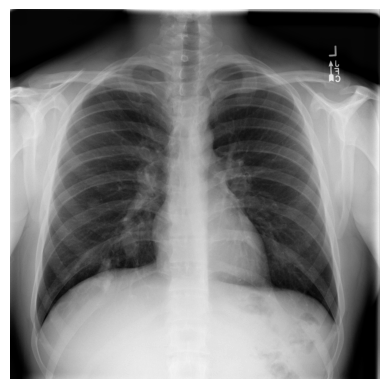

After pre-processing: 
Image min: 0.00392156862745098, max: 1.0


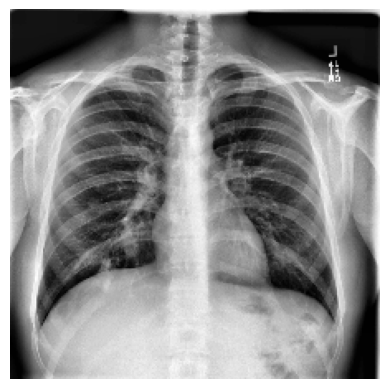

After augmentation: 
Augmented image min: 0.0, max: 1.0


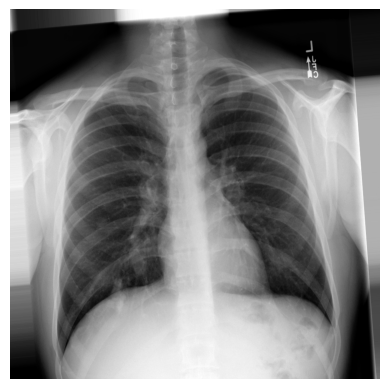

Augmented image min: 0.0, max: 0.8862745761871338


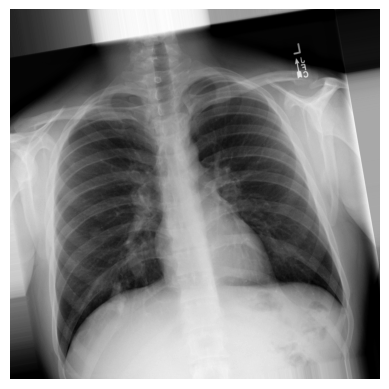

In [ ]:

image_path = os.path.join('/content/drive/My Drive/MLOPs Project/sampled_data', sample)
print("Before pre-processing: ")
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
print(f"Image min: {image.min()}, max: {image.max()}")
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

print("After pre-processing: ")
preprocessed_image = preprocess_image(image_path)
print(f"Image min: {preprocessed_image.min()}, max: {preprocessed_image.max()}")
plt.imshow(preprocessed_image, cmap='gray')
plt.axis('off')
plt.show()

print("After augmentation: ")
augmentation_generator = ImageDataGenerator(
      rescale=1.0 / 255.0,
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      brightness_range=[0.8, 1.2],
      zoom_range=0.1
  )
#augmentation_generator = ImageDataGenerator()
aug_images= apply_augmentation(image, augmentation_generator)
for aug_image in aug_images:
  print(f"Augmented image min: {aug_image.min()}, max: {aug_image.max()}")
  plt.imshow(aug_image, cmap='gray')
  plt.axis('off')
  plt.show()

In [12]:
json_path = '/content/drive/My Drive/MLOPs Project/labels_to_indices.json'
csv_path = '/content/drive/My Drive/MLOPs Project/sampled_data_entry.csv'
df = pd.read_csv(csv_path)
label_indices = load_label_indices(json_path)
augmented_indices= get_augmented_indices(label_indices, len(df))

class_counts:  {'14': 199, '11': 849, '0': 900, '3': 777, '7': 694, '8': 750, '2': 700, '5': 734, '1': 766, '13': 775, '12': 809, '10': 638, '9': 697, '4': 805, '6': 697}
